# Drive mount

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/git_project/AnomalyDetection/src")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install pakages

In [2]:
# !pip install -r ../requirements.txt
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install -c pytorch faiss-gpu -y

# Import modules

In [3]:
!nvidia-smi

Sun Oct  1 10:08:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import pickle

os.chdir("../src")

# import custom modules
from utils import seed_everything_custom, show_result_image, show_accuracies_auroc
from dataset.utils import reform_mvtec_dir_tree, get_dataset, get_dataloader
from dataset.transformers import Transformers
from model.models import PatchCoreModel
from trainers import Trainer
from testers import Tester
from utils import show_accuracies_auroc, show_result_image, show_score_distribution
from configs import Configs

# Configs

In [5]:
configs = Configs()
configs.DATA_ROOT = "../data"
configs.MODEL_ROOT = "../models"
configs.RESULT_ROOT = "../results"
configs.TARGET_DATASET_NAMES = ["bottle", "toothbrush","zipper","grid"]
configs.IMAGE_SIZE = 256
configs.BATCH_SIZE = 2
configs.BACKBONE_NAME = "wideresnet50"
configs.DEVICE = "cuda"

# Save Dataset to DATA_ROOT

In [27]:
reform_mvtec_dir_tree(
    source_dir=f"{configs.DATA_ROOT}/mvtec_original",
    target_dir=configs.DATA_ROOT
)

# Train & Validation

In [28]:
trainer = Trainer(configs)
trainer.run()

seed91, applied


                ====target:bottle::dimension:512====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 105/105 [00:14<00:00,  7.34it/s]


extracted all feature shape: (214016, 512)


Subsampling...: 100%|██████████| 42803/42803 [01:07<00:00, 635.01it/s]


sampled feature shape: (42803, 512)


42it [00:07,  5.46it/s]


dimension512's accuracy:1.0'


                ====target:bottle::dimension:1024====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 105/105 [00:15<00:00,  7.00it/s]


extracted all feature shape: (214016, 1024)


Subsampling...: 100%|██████████| 42803/42803 [01:09<00:00, 614.78it/s]


sampled feature shape: (42803, 1024)


42it [00:06,  6.90it/s]


dimension1024's accuracy:0.9879518072289156'
TEST ACCURACY:1.0, TEST AUROC:0.9836030475310815


                ====target:toothbrush::dimension:512====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30/30 [00:07<00:00,  4.19it/s]


extracted all feature shape: (61440, 512)


Subsampling...: 100%|██████████| 12288/12288 [00:06<00:00, 1916.14it/s]


sampled feature shape: (12288, 512)


21it [00:03,  5.75it/s]


dimension512's accuracy:0.9285714285714286'


                ====target:toothbrush::dimension:1024====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30/30 [00:07<00:00,  4.22it/s]


extracted all feature shape: (61440, 1024)


Subsampling...: 100%|██████████| 12288/12288 [00:06<00:00, 1914.78it/s]


sampled feature shape: (12288, 1024)


21it [00:03,  6.14it/s]


dimension1024's accuracy:0.9285714285714286'
TEST ACCURACY:0.9285714285714286, TEST AUROC:0.9883469187727296


                ====target:zipper::dimension:512====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:13<00:00,  8.96it/s]


extracted all feature shape: (245760, 512)


Subsampling...: 100%|██████████| 49152/49152 [01:34<00:00, 521.27it/s]


sampled feature shape: (49152, 512)


76it [00:10,  7.29it/s]


dimension512's accuracy:0.9735099337748344'


                ====target:zipper::dimension:1024====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:13<00:00,  8.88it/s]


extracted all feature shape: (245760, 1024)


Subsampling...: 100%|██████████| 49152/49152 [01:36<00:00, 509.72it/s]


sampled feature shape: (49152, 1024)


76it [00:10,  6.96it/s]


dimension1024's accuracy:0.9735099337748344'
TEST ACCURACY:0.9735099337748344, TEST AUROC:0.9893405180660804


                ====target:grid::dimension:512====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 132/132 [00:13<00:00,  9.59it/s]


extracted all feature shape: (270336, 512)


Subsampling...: 100%|██████████| 54067/54067 [01:56<00:00, 463.69it/s]


sampled feature shape: (54067, 512)


39it [00:05,  7.66it/s]


dimension512's accuracy:0.9743589743589743'


                ====target:grid::dimension:1024====
                

                


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 132/132 [00:17<00:00,  7.71it/s]


extracted all feature shape: (270336, 1024)


Subsampling...: 100%|██████████| 54067/54067 [01:56<00:00, 464.02it/s]


sampled feature shape: (54067, 1024)


39it [00:07,  5.50it/s]


dimension1024's accuracy:0.9615384615384616'
TEST ACCURACY:0.9743589743589743, TEST AUROC:0.9861320593630967


# Load valid results

In [29]:
results = {}
for key in configs.TARGET_DATASET_NAMES:
    result_path = os.path.join(configs.RESULT_ROOT, key, "result.pkl")
    with open(result_path, "rb") as f:
        results[key] = pickle.load(f)

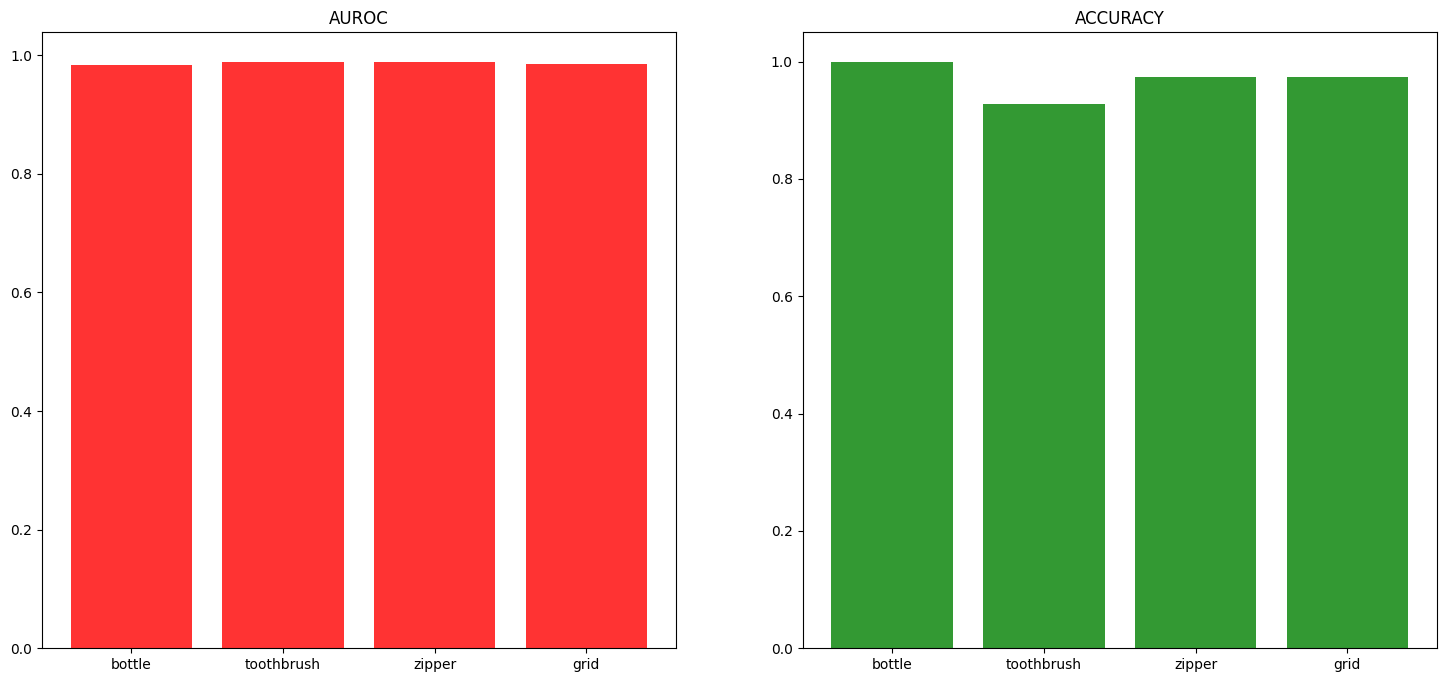

In [30]:
show_accuracies_auroc(results)

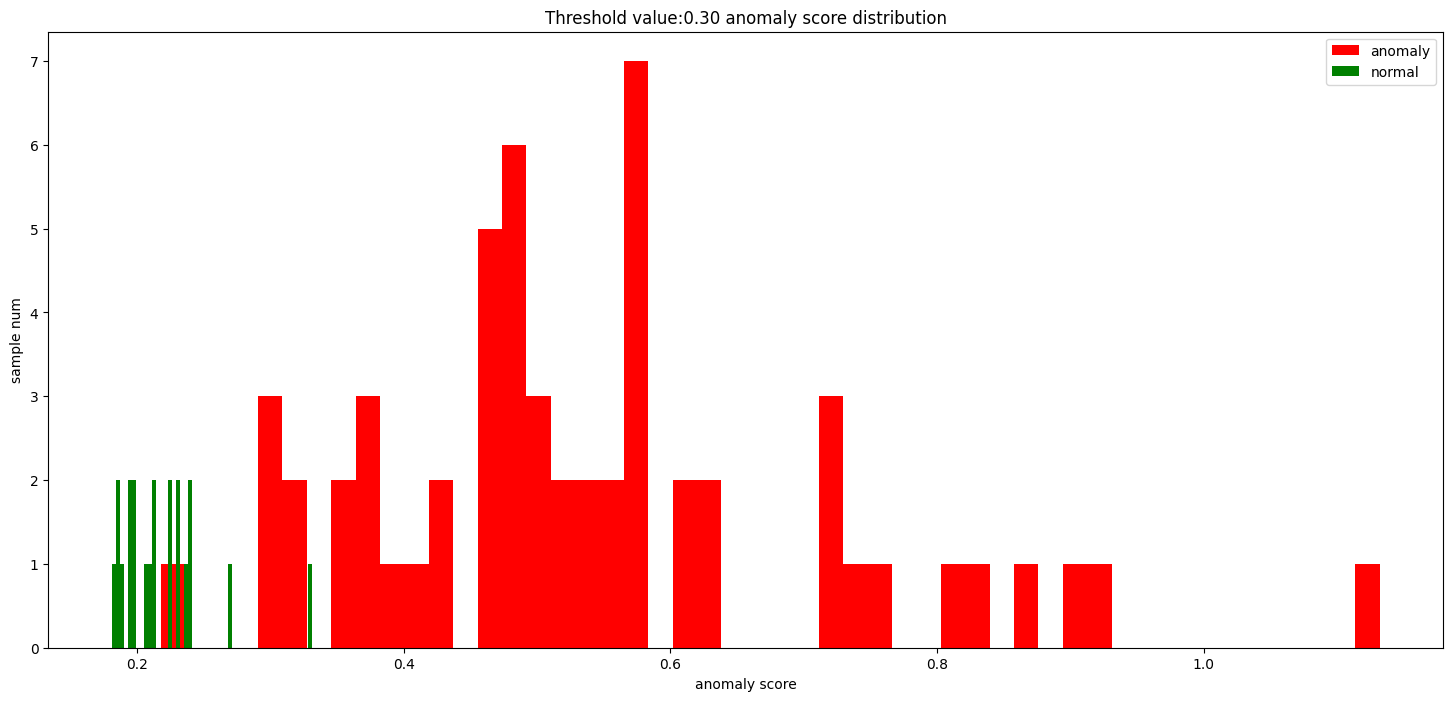

In [32]:
show_score_distribution(results["grid"])

In [33]:
show_result_image(results["grid"], num=10)

Output hidden; open in https://colab.research.google.com to view.

# Inference

In [35]:
tester = Tester(configs)
tester.run(
    model_path = os.path.join(configs.MODEL_ROOT, "bottle"),
    target_path = os.path.join(configs.DATA_ROOT, "bottle", "valid"),
    output_path = os.path.join(configs.RESULT_ROOT, "bottle")
)

seed91, applied


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
42it [00:05,  7.05it/s]
